enter max camber2
enter position4
enter discretized points100
enter chord length2
Enter at which aoa6
Analysis over Cambered airfoil 
enter number of fourier coefficients8
A_ 0 = -0.00449288637939343
A_ 1 = 0.0814951416008563
A_ 2 = 0.0138612764663765
A_ 3 = 0.00277225529327528
A_ 4 = -0.00210691402288922
A_ 5 = -0.00148592883719556
A_ 6 = 0.000478412056325228
A_ 7 = 0.000886488035495339
zero_lift_aoa in deg= -2.07724040490399
at aoa(in deg)  6.0 Cl is 0.885768527209968
C_M_quarter= -0.0531195134600912


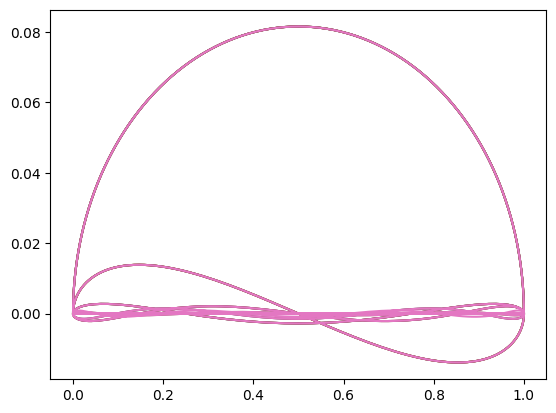

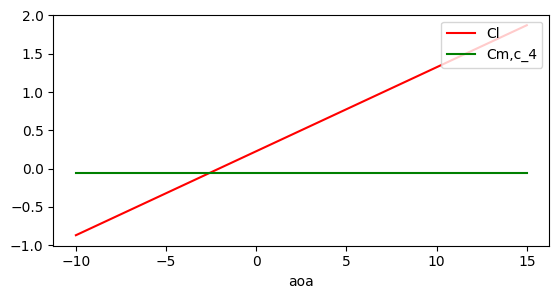

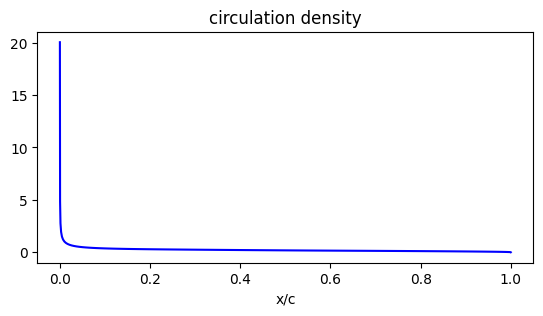

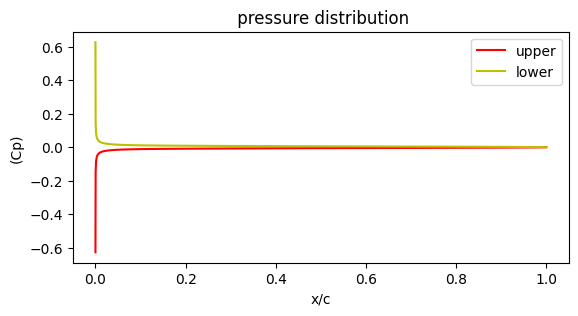

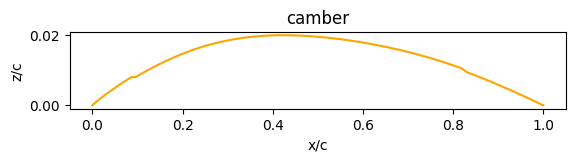

In [ ]:
''' Define a class to find various outputs of NACA 4 digit Airfoil using Only vortex sheet according to Thin airfoil theory'''

from numpy.core.multiarray import nested_iters
from sympy.functions.elementary.trigonometric import cos
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import math
import sympy as sym
import numpy as np
v=32 # Considering  free stream Velocity as unit
class outputs(object):
  def parameters(self,**kwargs): # passing various argument
    self.m=float(input('enter max camber'))/100
    self.p=float(input('enter position'))/10
    self.npts=int(input('enter discretized points')) # number of divisions one can want to make the vortex sheet
    self.chord=int(input('enter chord length'))
    self.aoa=float(input('Enter at which aoa')) # angle of attack

    if self.m==0 and self.p==0:   # for flate plate, no need to incorporate camber and thickness
      print('Analysis over symmetric airfoil')

      self.flate_plate(self.aoa,self.npts)
    else:    # for thin airfoi(NACA 4 digit series), no need to incorporate  thickness
      print('Analysis over Cambered airfoil ')

      self.nsrs=int(input('enter number of fourier coefficients')) # How many coeffients of fourier series
      self.cambered_plate()
      self.coefficients()
      self.ghama()
      self.fourier_component()



  def flate_plate(self,aoa,npts):
    self.x_axis=[]
    self.ghama=[]
    self.cp_u=[]
    self.cp_l=[]
    dtheta=self.chord/self.npts

    #To find local circulation density at each  discritized point
    for x in np.arange(0,self.chord+dtheta,dtheta):
      z=x/self.chord
      j=((self.chord-x)/x)**0.5
      i=(2*aoa*math.pi*v*j)/180
      self.x_axis.append(z)
      self.ghama.append(i)
    figure, axis = plt.subplots(2)
    axis[0].plot(self.x_axis,self.ghama,color='b') # plotting graph between local circulation and x/c
    plt.xlabel('x/c')
    plt.ylabel("local circulation")
    plt.subplots_adjust(hspace=1)

    # find coefficient of pressure on both upper and lower surface
    for i in range(0,len(self.ghama)):
      u=(-1/v)*self.ghama[i]
      l=self.ghama[i]/v
      self.cp_u.append(u)
      self.cp_l.append(l)
    plt.plot(self.x_axis,self.cp_u,color='r')
    plt.plot(self.x_axis,self.cp_l,color='y')
    plt.xlabel('x/c')
    plt.ylabel("Coefficient of pressure (Cp)")
    plt.title("Variation of pressure distribution")
    plt.legend(['upper','lower'],loc='upper right')

    #find sectional lift coefficient and total circulation
    total=self.chord*aoa*math.pi**2*v/180
    cl=2*math.pi**2*aoa/180
    print('cl =', cl)



  def cambered_plate(self):
    self.a_n=[]
    self.empty=[]

    theta_p=math.acos(1-2*self.p)

    theta=sym.symbols('theta')
    self.x_axis=[]
    self.empty=[]
    dtheta=np.pi/self.npts   #step size of theta/chord axis

    # To find  fourier coefficients from A0 to nsrs-1
    for n in range(self.nsrs):
      z1=(self.m*(2*self.p-1+sym.cos(theta))/(self.p*self.p))*sym.cos(n*theta)   # Camber function of NACA 4 digit series
      dzc_dx1=sym.integrate(z1,(theta,0,theta_p))    #integrating the function from 0 to position of max camber
      dzc_dx2=sym.integrate((self.m*sym.cos(n*theta)*(2*self.p-1+sym.cos(theta))/(1-self.p)**2),(theta,theta_p,math.pi)) #integrating the function from  position of max camber to pi
      if n==0:    # To calculate A0
        c=(-1/math.pi)*(dzc_dx1+dzc_dx2)
      else:    # To calculate A1,A2,A3......
        c=(2/math.pi)*(dzc_dx1+dzc_dx2)
      self.a_n.append(c)    # an array that contains all coefficients
    for i in range(len(self.a_n)):
      print('A_',i,'=',self.a_n[i])


    dtheta=np.pi/self.npts
    for n in range(1,self.nsrs):   # To find Contribution of each Coefficient to local circulation
      for theta in np.arange(0,math.pi+dtheta,dtheta):
        z=(1-math.cos(theta))/2
        term2 =(self.a_n[n]*math.sin(n*theta)) #An*sin(n*theta)
        self.empty.append(term2)
        self.x_axis.append(z)
        #print(empty)
      plt.plot(self.x_axis,self.empty)


# Find Fourier Components
  def fourier_component(self):
    dtheta=np.pi/self.npts
    self.x_c=[]
    self.tht=[]
    # To store x_axis values in x/c terms using theta
    for theta in np.arange(0,math.pi+dtheta,dtheta):
      self.tht.append(theta)
      z=(1-math.cos(theta))/2
      self.x_c.append(z)
    self.zc=[]

    #Contribution of B0 and Bn*sin(n*theta) to the camber function
    # so this is a 2D array that contains Bn contribution at each point in the format of [B0o B01 B02.........'
                                                                                        #       B1O B11 B12........
                                                                                        #       B2O B21 B22........
                                                                                        #       ................Bnm.....]
                                                                                        # where n fixes the coefficient ,m fixes the location
    for n in range(len(self.a_n)):
      self.l=[]
      for j in range(len(self.tht)): # this loop is used to represent upto what theta we can integrate that term
        theta=0
        dzc=0
        while theta<=self.tht[j]:# this is to stop the integration of coefficient contirbution upto Theta
          constant=math.sin(theta)*math.cos(n*theta)*dtheta/2
          if n==0:
            dzc=dzc+(-self.a_n[n]*constant) #B0 contribution obtained by integrating from 0 to theta[j] and adding such terms
            theta=theta+dtheta
          else:
            dzc=dzc+(self.a_n[n]*constant)
            theta=theta+dtheta
        self.l.append(dzc) # so this array contains Bn contribution at each point
      self.zc.append(self.l)# so this our 2D array

    self.zcx=[]
    for i in range(len(self.x_c)):
      self.zcx_=0
      for j in range(len(self.a_n)):
        self.zcx_=self.zcx_+self.zc[j][i]  # adding contributions of each coeff at particular point to get czmber function at that point
      self.zcx.append(self.zcx_) # appending those values into new array to plot wrt x/c
    plt.figure().set_figheight(1)
    plt.plot(self.x_c,self.zcx,color='orange')
    plt.title('camber')
    plt.xlabel('x/c')
    plt.ylabel('z/c')
    plt.subplots_adjust(hspace=2)


  def ghama(self):# to find location circulation each point
    self.ghama=[]
    self.g=[]
    self.cp_u=[]
    self.cp_l=[]
    self.dtheta=math.pi/self.npts
    for theta in np.arange(0.01,math.pi+self.dtheta,self.dtheta):
      series=(((1+math.cos(theta))*self.a_n[0])/math.sin(theta)) # to get A0 (1+costheta)/sin(theta) at each theta
      for n in range(1,len(self.a_n)):
        series+=(self.a_n[n]*math.sin((n)*theta)) # to get  summation of An*sin(n*theta)
      series+=(self.aoa*np.pi/180)*((1+math.cos(theta))/math.sin(theta)) # incorporating the circulation of AOA problem also, as our NACA 4 digit is a thin airfoil
      self.ghama.append(series)
      self.cp_u.append(-series/v) #finding upper surface pressure distribution
      self.cp_l.append(series/v) #finding lower surface pressure distribution
      x=(1-math.cos(theta))/2
      self.g.append(x)
    theta=0

    plt.figure().set_figheight(3)
    plt.plot(self.g,self.ghama,color='b') #plotting local circulation
    plt.title('circulation density')
    plt.xlabel('x/c')
    plt.subplots_adjust(hspace=2)

    plt.figure().set_figheight(3)
    plt.plot(self.g,self.cp_u,color='r')
    plt.plot(self.g,self.cp_l,color='y') #plotting Cp variation
    plt.xlabel('x/c')
    plt.ylabel("(Cp)")
    plt.title(" pressure distribution")
    plt.legend(['upper','lower'],loc='upper right')


  def coefficients(self):
    zero_lift_aoa=-(self.a_n[0]+(self.a_n[1]/2))
    print('zero_lift_aoa in deg=',zero_lift_aoa*180/math.pi)

    Cl=(math.pi*((2*self.a_n[0])+self.a_n[1]))+(2*math.pi**2*self.aoa/180)  # To find Lift coefficient,Moment coefficient c/4
    print('at aoa(in deg) ',self.aoa,'Cl is',Cl)
    C_M_quarter=-((math.pi/4)*(self.a_n[1]-self.a_n[2]))
    print('C_M_quarter=',C_M_quarter)

    ## plot Cl Vs aoa and Cm c/4 Vs aoa
    self.cl=[]
    self.cm=[]
    self.alpha=[]
    for angle in np.linspace(-10,15,10):
      Cl=(math.pi*((2*self.a_n[0])+self.a_n[1]))+(2*math.pi**2*angle/180) # as our thin airfoil theory is a linearized problem.we can directly add outputs of aoa and camber problem
      self.cl.append(Cl)
      C_M_c4=-((math.pi/4)*(self.a_n[1]-self.a_n[2]))
      self.cm.append(C_M_c4)
      self.alpha.append(angle)
    plt.figure().set_figheight(3)
    plt.plot(self.alpha,self.cl,color='red')
    plt.plot(self.alpha,self.cm,color='green')
    plt.xlabel('aoa')
    plt.legend(['Cl','Cm,c_4'],loc='upper right')
    plt.subplots_adjust(hspace=2)






run=outputs()
run.parameters()


Enter the left bottom  x co-ordinate of grid
-4
Enter the left bottom  y co-ordinate of grid
-4
Enter the right top  x co-ordinate of grid
4
Enter the right top y co-ordinate of grid
4


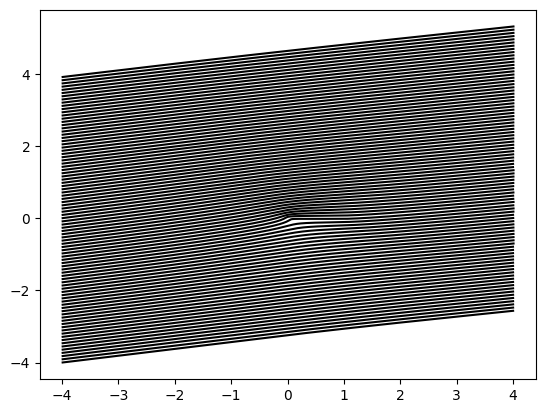

In [ ]:
group6= outputs()
#For flat plate, the velocity vector is due to perturbations and free stream
class streamline(object):
  def __init__(self,b):
    print("Enter the left bottom  x co-ordinate of grid")
    x0=int(input())
    print("Enter the left bottom  y co-ordinate of grid")
    z0=int(input())
    print("Enter the right top  x co-ordinate of grid")
    x_=int(input())
    print("Enter the right top y co-ordinate of grid")
    z_=int(input())
    ds=0.01
    zeta=[]
    v=1
    self.theta1=[]
    self.dtheta=np.pi/100
    theta=0
    self.x5=[]
    # self.x6=[]
    while(theta<=(np.pi-self.dtheta)):
      theta=theta+self.dtheta
      dxx=0.5*(1-np.cos(theta))
      self.theta1.append(theta)
      self.x5.append(dxx)

    self.b  = group6
    self.b.aoa= 10
    gamma=[]
    for i in range(len(self.x5)):
      gamma1=2*self.b.aoa*np.pi/180*v*np.sqrt((self.x5[len(self.x5)-1]-self.x5[i])/self.x5[i])
      gamma.append(gamma1)
      zeta.append(self.x5[i])
    # print(len(zeta))
    # print(len(gammax))
    x=x0
    z=z0
    u1=0
    w1=0
    i=0
    x1=[]
    z1=[]
    z_f =(z_-z)/90
    z2 = z0
    while(z <= z_):
      while(x<=x_):
        while(zeta[i]<=zeta[len(zeta)-2]):
          if(zeta[i]==zeta[len(zeta)-1]):
            dzeta=0.001
          else:
            dzeta=zeta[i+1]-zeta[i]
          du=gamma[i]/(2*np.pi)*(z*dzeta/((x-zeta[i])**2+z**2))
          dw=-1*gamma[i]/(2*np.pi)*(x-zeta[i])*dzeta/((x-zeta[i])**2+z**2)
          u1=u1+du
          w1=w1+dw
          i=i+1
        U=u1+v*np.cos(self.b.aoa*np.pi/180)
        W=w1+v*np.sin(self.b.aoa*np.pi/180)
        thetax=np.arctan(W/U)
        x=x+ds*np.cos(thetax)
        z=z+ds*np.sin(thetax)
        w1=0
        u1=0
        i=0
        x1.append(x)
        z1.append(z)
      # print(len(x1))
      # print(len(z1))

      plt.plot(x1,z1, color = 'black')
      z = z2 + z_f
      z2 = z2 + z_f
      x1=[]
      z1=[]

      x=x0


b= streamline(group6)
